In [16]:
import pandas as pd
import os 
import sys
import numpy as np
import sklearn
import time
import copy
from collections import defaultdict

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
#create single pose dataset for dnn model
class SinglePoseDataset(Dataset):
    
    def __init__(self, n_frames=5):
        
        # get data and label from csvget 
        dataset, labels = SinglePoseDataset.ReadPoseData(n_frames)
        
        self.X = dataset
        self.y = labels
    
    # read dataset from csv file
    @staticmethod
    def ReadPoseData(n_frames):
        
        # get csv file path
        curr_dir = os.getcwd()
        csv_file_path = os.path.join(curr_dir, 'data/res.csv')
        
        # list for storing data and labels
        data  = []
        label = []
        
        # lenth of sequence
        #n_frames = SinglePoseDataset.n_frames
        
        # read csv file
        KP_df = pd.read_csv(csv_file_path)
        
        # convert pos_class to categories
        KP_df['pos_class'] = KP_df['pos_class'].astype('category')
        KP_df['pos_class'] = KP_df['pos_class'].cat.codes

        # skipping (0-3) colomns , return values of all rows and columns from 4 to last
        features = KP_df.iloc[:,4:].values
        #return values of pose_class 
        pose_class = KP_df['pos_class'].values
        # normalize keypoints 
        SinglePoseDataset.normalize_min_(features)
        # append multiple rows to create a sequence of data
        for i in range(features.shape[0]-n_frames):
            data.append(features[i:i+n_frames,...])
            label_sequence = pose_class[i:i+n_frames]
            unique, counts = np.unique(label_sequence, return_counts=True)
            label.append(unique[np.argmax(counts)])
            
        data , label =  np.array(data, dtype = np.float), np.array(label, dtype = np.int_)
        
        return data , label
    
    # min-max normalization to scale the x, y coordinates in range (0-1) 
    @staticmethod
    def normalize_min_(pose:np.ndarray):
        pose = pose.reshape(len(pose),-1,2)
        for i in range(len(pose)):
            xmin = np.min(pose[i,:,0]) 
            ymin = np.min(pose[i,:,1])
            xlen = np.max(pose[i,:,0]) - xmin
            ylen = np.max(pose[i,:,1]) - ymin

            if(xlen==0): pose[i,:,0]=0
            else:
                pose[i,:,0] -= xmin 
                pose[i,:,0] /= xlen

            if(ylen==0): pose[i,:,1]=0
            else:
                pose[i,:,1] -= ymin
                pose[i,:,1] /= ylen
        return pose
    
    # number of rows in the dataset
    def __len__(self):
        
        return len(self.X)
        
    # get a row at an index
    def __getitem__(self, idx):
        
        data  = torch.tensor(self.X[idx], dtype=torch.float) 
        label = torch.tensor(self.y[idx], dtype=torch.long)
        
        return [data,label]
    
    # get indexes for train and test rows
    def get_splits(self, n_test = 0.33):
        
        # determine sizes 
        test_size = round(n_test * len(self.X))
        train_size = len(self.X)-test_size
        
        # calculate the split 
        return random_split(self, [train_size, test_size])
    
    def get_class_labels(self):
        
        labels = ["Fall","Stand", "Tie"]
        
        return labels
    
    def reshape_features(self):
        self.X = self.X.reshape(-1, self.X.shape[1]*self.X.shape[2])

In [18]:
class DNN_Single(torch.nn.Module):
    
    def __init__(self, input_dim, class_num, initrange=0.5):
        
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64,16)
        self.bn3 = torch.nn.BatchNorm1d(16)
        self.fc4 = torch.nn.Linear(16, class_num)
        self.class_num = class_num
        self.init_weights(initrange)
    
    def init_weights(self, initrange):
        
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()
        self.fc3.weight.data.uniform_(-initrange, initrange)
        self.fc3.bias.data.zero_()
        self.fc4.weight.data.uniform_(-initrange, initrange)
        self.fc4.bias.data.zero_()
    
    def forward(self, _input):
        
        _fc1 = F.relu(self.fc1(_input))
        
        _bn1 = self.bn1(_fc1)
        
        _fc2 = F.relu(self.fc2(_bn1))
        _bn2 = self.bn2(_fc2)
        
        _fc3 = F.relu(self.fc3(_bn2))
        _bn3 = self.bn3(_fc3)
        
        _fc4 = self.fc4(_bn3)
        
        output = F.softmax(_fc4, dim=1)
        
        return output

In [19]:
def prepare_data():
    
    # load pose dataset
    dataset = SinglePoseDataset(n_frames=5)
    
    # reshape from N,10,34 to N,340
    dataset.reshape_features()
    
    # calculate split size
    train,  test = dataset.get_splits()
    
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=16, shuffle=True)
    val_dl  = DataLoader(test, batch_size=1024, shuffle=False)
    
    return {'train':train_dl, 'val':val_dl}, {'train':train, 'val':test}

In [20]:
def save_model(model, optimizer, loss, acc, epoch, save_path):
    
    base_dir = os.path.basename(os.getcwd())
    
    if base_dir =='train':
        parent_dir = os.path.dirname(os.getcwd())
        os.chdir(parent_dir)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
    
    print('SAVING EPOCH %d'%epoch)
    
    SAVE_FILE = os.path.join(save_path,'epoch_%d.pth'%epoch)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'acc':  acc,
            }, SAVE_FILE)
    

In [21]:
def train_model(model, num_epochs=3000):
    
    
    history = defaultdict(list)
    #get train and val dataloaders
    dataloaders, dataset_sizes = prepare_data()

    # define the optimization
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # enumerate over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # St model to training mode
            
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0.0
            
            # enumerate over mini_batch
            for i, (inputs, targets)  in enumerate(dataloaders[phase]):
                inputs  = inputs.to(device)
                targets = targets.to(device)
                
                # clear the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train pahse
                with torch.set_grad_enabled(phase=='train'):
                    
                    # compute model outputs
                    outputs = model(inputs)
                    
                    # calculate outputs
                    _, preds = torch.max(outputs, dim=1)
                    
                    # calculate the loss
                    loss = criterion(outputs, targets)
                    
                    # backward + optimize only ig in training phase
                    if phase == 'train':
                        # calculate gradient
                        loss.backward()
                    
                        # update model weights
                        optimizer.step()
                
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==targets)
            
            if phase=='train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase].__len__()
            epoch_acc  = running_corrects.double() / dataset_sizes[phase].__len__()
            
            
            history[phase].append((epoch_loss, epoch_acc))
            
            print('{} Loss: {:.4f} Acc {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase== 'val' and epoch_acc> best_acc:
                best_acc = epoch_acc
                save_model(model, optimizer, epoch_loss, epoch_acc, epoch, save_path=r'model/act_dnnSingle_10')
        print()
    
    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed //60, time_elapsed %60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    return history

In [24]:
DNN_model = DNN_Single(input_dim=170,class_num=3).to(device)

In [25]:
history = train_model(DNN_model, num_epochs=1000)

Epoch 0/999
----------
train Loss: 0.6591 Acc 0.8987
val Loss: 0.6081 Acc 0.9433
SAVING EPOCH 0

Epoch 1/999
----------
train Loss: 0.6235 Acc 0.9275
val Loss: 0.5973 Acc 0.9531
SAVING EPOCH 1

Epoch 2/999
----------
train Loss: 0.6118 Acc 0.9393
val Loss: 0.5941 Acc 0.9569
SAVING EPOCH 2

Epoch 3/999
----------
train Loss: 0.6052 Acc 0.9453
val Loss: 0.5867 Acc 0.9641
SAVING EPOCH 3

Epoch 4/999
----------
train Loss: 0.6043 Acc 0.9462
val Loss: 0.5896 Acc 0.9617

Epoch 5/999
----------
train Loss: 0.5999 Acc 0.9508
val Loss: 0.5877 Acc 0.9637

Epoch 6/999
----------
train Loss: 0.5950 Acc 0.9559
val Loss: 0.5845 Acc 0.9668
SAVING EPOCH 6

Epoch 7/999
----------
train Loss: 0.5932 Acc 0.9579
val Loss: 0.5793 Acc 0.9716
SAVING EPOCH 7

Epoch 8/999
----------
train Loss: 0.5921 Acc 0.9581
val Loss: 0.5803 Acc 0.9711

Epoch 9/999
----------
train Loss: 0.5906 Acc 0.9606
val Loss: 0.5782 Acc 0.9724
SAVING EPOCH 9

Epoch 10/999
----------
train Loss: 0.5890 Acc 0.9619
val Loss: 0.5785 Acc 

train Loss: 0.5612 Acc 0.9902
val Loss: 0.5657 Acc 0.9853
SAVING EPOCH 95

Epoch 96/999
----------
train Loss: 0.5625 Acc 0.9889
val Loss: 0.5661 Acc 0.9853

Epoch 97/999
----------
train Loss: 0.5615 Acc 0.9898
val Loss: 0.5677 Acc 0.9828

Epoch 98/999
----------
train Loss: 0.5620 Acc 0.9895
val Loss: 0.5687 Acc 0.9825

Epoch 99/999
----------
train Loss: 0.5607 Acc 0.9905
val Loss: 0.5669 Acc 0.9842

Epoch 100/999
----------
train Loss: 0.5606 Acc 0.9908
val Loss: 0.5672 Acc 0.9840

Epoch 101/999
----------
train Loss: 0.5590 Acc 0.9922
val Loss: 0.5658 Acc 0.9856
SAVING EPOCH 101

Epoch 102/999
----------
train Loss: 0.5598 Acc 0.9917
val Loss: 0.5655 Acc 0.9854

Epoch 103/999
----------
train Loss: 0.5587 Acc 0.9929
val Loss: 0.5655 Acc 0.9860
SAVING EPOCH 103

Epoch 104/999
----------
train Loss: 0.5588 Acc 0.9927
val Loss: 0.5650 Acc 0.9863
SAVING EPOCH 104

Epoch 105/999
----------
train Loss: 0.5589 Acc 0.9926
val Loss: 0.5650 Acc 0.9863

Epoch 106/999
----------
train Loss: 0

train Loss: 0.5563 Acc 0.9952
val Loss: 0.5658 Acc 0.9852

Epoch 192/999
----------
train Loss: 0.5563 Acc 0.9950
val Loss: 0.5649 Acc 0.9866

Epoch 193/999
----------
train Loss: 0.5565 Acc 0.9950
val Loss: 0.5658 Acc 0.9856

Epoch 194/999
----------
train Loss: 0.5559 Acc 0.9955
val Loss: 0.5660 Acc 0.9852

Epoch 195/999
----------
train Loss: 0.5559 Acc 0.9956
val Loss: 0.5662 Acc 0.9852

Epoch 196/999
----------
train Loss: 0.5565 Acc 0.9950
val Loss: 0.5661 Acc 0.9850

Epoch 197/999
----------
train Loss: 0.5566 Acc 0.9947
val Loss: 0.5652 Acc 0.9857

Epoch 198/999
----------
train Loss: 0.5562 Acc 0.9952
val Loss: 0.5669 Acc 0.9844

Epoch 199/999
----------
train Loss: 0.5568 Acc 0.9944
val Loss: 0.5646 Acc 0.9864

Epoch 200/999
----------
train Loss: 0.5564 Acc 0.9950
val Loss: 0.5646 Acc 0.9869

Epoch 201/999
----------
train Loss: 0.5562 Acc 0.9952
val Loss: 0.5647 Acc 0.9868

Epoch 202/999
----------
train Loss: 0.5558 Acc 0.9955
val Loss: 0.5648 Acc 0.9864

Epoch 203/999
---

train Loss: 0.5563 Acc 0.9952
val Loss: 0.5688 Acc 0.9824

Epoch 290/999
----------
train Loss: 0.5557 Acc 0.9955
val Loss: 0.5652 Acc 0.9861

Epoch 291/999
----------
train Loss: 0.5560 Acc 0.9954
val Loss: 0.5651 Acc 0.9861

Epoch 292/999
----------
train Loss: 0.5555 Acc 0.9959
val Loss: 0.5648 Acc 0.9865

Epoch 293/999
----------
train Loss: 0.5561 Acc 0.9953
val Loss: 0.5646 Acc 0.9871

Epoch 294/999
----------
train Loss: 0.5558 Acc 0.9957
val Loss: 0.5647 Acc 0.9866

Epoch 295/999
----------
train Loss: 0.5558 Acc 0.9956
val Loss: 0.5650 Acc 0.9858

Epoch 296/999
----------
train Loss: 0.5554 Acc 0.9958
val Loss: 0.5675 Acc 0.9836

Epoch 297/999
----------
train Loss: 0.5554 Acc 0.9962
val Loss: 0.5656 Acc 0.9852

Epoch 298/999
----------
train Loss: 0.5562 Acc 0.9951
val Loss: 0.5663 Acc 0.9849

Epoch 299/999
----------
train Loss: 0.5556 Acc 0.9957
val Loss: 0.5646 Acc 0.9865

Epoch 300/999
----------
train Loss: 0.5561 Acc 0.9953
val Loss: 0.5654 Acc 0.9860

Epoch 301/999
---

train Loss: 0.5564 Acc 0.9948
val Loss: 0.5641 Acc 0.9871

Epoch 388/999
----------
train Loss: 0.5561 Acc 0.9955
val Loss: 0.5683 Acc 0.9830

Epoch 389/999
----------
train Loss: 0.5555 Acc 0.9960
val Loss: 0.5667 Acc 0.9845

Epoch 390/999
----------
train Loss: 0.5555 Acc 0.9960
val Loss: 0.5646 Acc 0.9867

Epoch 391/999
----------
train Loss: 0.5554 Acc 0.9960
val Loss: 0.5643 Acc 0.9872

Epoch 392/999
----------
train Loss: 0.5554 Acc 0.9961
val Loss: 0.5646 Acc 0.9867

Epoch 393/999
----------
train Loss: 0.5556 Acc 0.9957
val Loss: 0.5669 Acc 0.9839

Epoch 394/999
----------
train Loss: 0.5559 Acc 0.9956
val Loss: 0.5645 Acc 0.9866

Epoch 395/999
----------
train Loss: 0.5552 Acc 0.9960
val Loss: 0.5648 Acc 0.9862

Epoch 396/999
----------
train Loss: 0.5558 Acc 0.9958
val Loss: 0.5680 Acc 0.9830

Epoch 397/999
----------
train Loss: 0.5567 Acc 0.9946
val Loss: 0.5651 Acc 0.9862

Epoch 398/999
----------
train Loss: 0.5563 Acc 0.9952
val Loss: 0.5647 Acc 0.9865

Epoch 399/999
---

train Loss: 0.5560 Acc 0.9954
val Loss: 0.5658 Acc 0.9855

Epoch 486/999
----------
train Loss: 0.5558 Acc 0.9955
val Loss: 0.5650 Acc 0.9863

Epoch 487/999
----------
train Loss: 0.5562 Acc 0.9952
val Loss: 0.5647 Acc 0.9866

Epoch 488/999
----------
train Loss: 0.5555 Acc 0.9960
val Loss: 0.5688 Acc 0.9823

Epoch 489/999
----------
train Loss: 0.5556 Acc 0.9957
val Loss: 0.5644 Acc 0.9869

Epoch 490/999
----------
train Loss: 0.5562 Acc 0.9953
val Loss: 0.5650 Acc 0.9858

Epoch 491/999
----------
train Loss: 0.5559 Acc 0.9954
val Loss: 0.5644 Acc 0.9869

Epoch 492/999
----------
train Loss: 0.5559 Acc 0.9955
val Loss: 0.5646 Acc 0.9865

Epoch 493/999
----------
train Loss: 0.5556 Acc 0.9960
val Loss: 0.5651 Acc 0.9861

Epoch 494/999
----------
train Loss: 0.5559 Acc 0.9956
val Loss: 0.5645 Acc 0.9870

Epoch 495/999
----------
train Loss: 0.5557 Acc 0.9956
val Loss: 0.5647 Acc 0.9868

Epoch 496/999
----------
train Loss: 0.5560 Acc 0.9955
val Loss: 0.5648 Acc 0.9862

Epoch 497/999
---

train Loss: 0.5554 Acc 0.9959
val Loss: 0.5693 Acc 0.9820

Epoch 584/999
----------
train Loss: 0.5556 Acc 0.9959
val Loss: 0.5646 Acc 0.9866

Epoch 585/999
----------
train Loss: 0.5551 Acc 0.9962
val Loss: 0.5644 Acc 0.9865

Epoch 586/999
----------
train Loss: 0.5560 Acc 0.9954
val Loss: 0.5648 Acc 0.9861

Epoch 587/999
----------
train Loss: 0.5555 Acc 0.9958
val Loss: 0.5674 Acc 0.9838

Epoch 588/999
----------
train Loss: 0.5555 Acc 0.9960
val Loss: 0.5677 Acc 0.9837

Epoch 589/999
----------
train Loss: 0.5561 Acc 0.9954
val Loss: 0.5643 Acc 0.9867

Epoch 590/999
----------
train Loss: 0.5559 Acc 0.9954
val Loss: 0.5671 Acc 0.9843

Epoch 591/999
----------
train Loss: 0.5561 Acc 0.9952
val Loss: 0.5647 Acc 0.9864

Epoch 592/999
----------
train Loss: 0.5553 Acc 0.9962
val Loss: 0.5650 Acc 0.9862

Epoch 593/999
----------
train Loss: 0.5562 Acc 0.9953
val Loss: 0.5640 Acc 0.9875

Epoch 594/999
----------
train Loss: 0.5562 Acc 0.9950
val Loss: 0.5653 Acc 0.9857

Epoch 595/999
---

train Loss: 0.5552 Acc 0.9963
val Loss: 0.5650 Acc 0.9861

Epoch 682/999
----------
train Loss: 0.5560 Acc 0.9956
val Loss: 0.5655 Acc 0.9858

Epoch 683/999
----------
train Loss: 0.5561 Acc 0.9952
val Loss: 0.5652 Acc 0.9857

Epoch 684/999
----------
train Loss: 0.5555 Acc 0.9960
val Loss: 0.5650 Acc 0.9858

Epoch 685/999
----------
train Loss: 0.5559 Acc 0.9955
val Loss: 0.5642 Acc 0.9868

Epoch 686/999
----------
train Loss: 0.5551 Acc 0.9964
val Loss: 0.5647 Acc 0.9862

Epoch 687/999
----------
train Loss: 0.5559 Acc 0.9956
val Loss: 0.5645 Acc 0.9863

Epoch 688/999
----------
train Loss: 0.5558 Acc 0.9955
val Loss: 0.5646 Acc 0.9867

Epoch 689/999
----------
train Loss: 0.5558 Acc 0.9955
val Loss: 0.5649 Acc 0.9862

Epoch 690/999
----------
train Loss: 0.5557 Acc 0.9958
val Loss: 0.5686 Acc 0.9825

Epoch 691/999
----------
train Loss: 0.5560 Acc 0.9953
val Loss: 0.5642 Acc 0.9871

Epoch 692/999
----------
train Loss: 0.5558 Acc 0.9958
val Loss: 0.5673 Acc 0.9841

Epoch 693/999
---

train Loss: 0.5557 Acc 0.9957
val Loss: 0.5659 Acc 0.9852

Epoch 780/999
----------
train Loss: 0.5553 Acc 0.9962
val Loss: 0.5647 Acc 0.9865

Epoch 781/999
----------
train Loss: 0.5555 Acc 0.9958
val Loss: 0.5652 Acc 0.9856

Epoch 782/999
----------
train Loss: 0.5559 Acc 0.9954
val Loss: 0.5642 Acc 0.9873

Epoch 783/999
----------
train Loss: 0.5564 Acc 0.9947
val Loss: 0.5645 Acc 0.9866

Epoch 784/999
----------
train Loss: 0.5556 Acc 0.9960
val Loss: 0.5693 Acc 0.9820

Epoch 785/999
----------
train Loss: 0.5554 Acc 0.9960
val Loss: 0.5697 Acc 0.9813

Epoch 786/999
----------
train Loss: 0.5559 Acc 0.9957
val Loss: 0.5650 Acc 0.9863

Epoch 787/999
----------
train Loss: 0.5555 Acc 0.9960
val Loss: 0.5639 Acc 0.9875

Epoch 788/999
----------
train Loss: 0.5557 Acc 0.9957
val Loss: 0.5643 Acc 0.9868

Epoch 789/999
----------
train Loss: 0.5555 Acc 0.9960
val Loss: 0.5640 Acc 0.9872

Epoch 790/999
----------
train Loss: 0.5556 Acc 0.9958
val Loss: 0.5678 Acc 0.9836

Epoch 791/999
---

train Loss: 0.5555 Acc 0.9960
val Loss: 0.5646 Acc 0.9865

Epoch 878/999
----------
train Loss: 0.5554 Acc 0.9960
val Loss: 0.5650 Acc 0.9861

Epoch 879/999
----------
train Loss: 0.5562 Acc 0.9952
val Loss: 0.5642 Acc 0.9874

Epoch 880/999
----------
train Loss: 0.5554 Acc 0.9961
val Loss: 0.5693 Acc 0.9816

Epoch 881/999
----------
train Loss: 0.5560 Acc 0.9955
val Loss: 0.5643 Acc 0.9866

Epoch 882/999
----------
train Loss: 0.5555 Acc 0.9958
val Loss: 0.5649 Acc 0.9866

Epoch 883/999
----------
train Loss: 0.5559 Acc 0.9954
val Loss: 0.5647 Acc 0.9866

Epoch 884/999
----------
train Loss: 0.5560 Acc 0.9950
val Loss: 0.5673 Acc 0.9839

Epoch 885/999
----------
train Loss: 0.5557 Acc 0.9956
val Loss: 0.5645 Acc 0.9865

Epoch 886/999
----------
train Loss: 0.5555 Acc 0.9960
val Loss: 0.5648 Acc 0.9866

Epoch 887/999
----------
train Loss: 0.5562 Acc 0.9953
val Loss: 0.5654 Acc 0.9856

Epoch 888/999
----------
train Loss: 0.5554 Acc 0.9959
val Loss: 0.5676 Acc 0.9838

Epoch 889/999
---

train Loss: 0.5562 Acc 0.9953
val Loss: 0.5649 Acc 0.9860

Epoch 976/999
----------
train Loss: 0.5557 Acc 0.9958
val Loss: 0.5647 Acc 0.9869

Epoch 977/999
----------
train Loss: 0.5554 Acc 0.9960
val Loss: 0.5680 Acc 0.9830

Epoch 978/999
----------
train Loss: 0.5563 Acc 0.9952
val Loss: 0.5644 Acc 0.9866

Epoch 979/999
----------
train Loss: 0.5563 Acc 0.9950
val Loss: 0.5651 Acc 0.9861

Epoch 980/999
----------
train Loss: 0.5564 Acc 0.9949
val Loss: 0.5649 Acc 0.9861

Epoch 981/999
----------
train Loss: 0.5557 Acc 0.9956
val Loss: 0.5691 Acc 0.9821

Epoch 982/999
----------
train Loss: 0.5563 Acc 0.9952
val Loss: 0.5649 Acc 0.9862

Epoch 983/999
----------
train Loss: 0.5551 Acc 0.9963
val Loss: 0.5673 Acc 0.9839

Epoch 984/999
----------
train Loss: 0.5556 Acc 0.9959
val Loss: 0.5643 Acc 0.9871

Epoch 985/999
----------
train Loss: 0.5555 Acc 0.9960
val Loss: 0.5694 Acc 0.9816

Epoch 986/999
----------
train Loss: 0.5558 Acc 0.9956
val Loss: 0.5646 Acc 0.9865

Epoch 987/999
---

In [26]:
train_acc  = []
train_loss = []
val_acc =  []
val_loss = []

for train_item, val_item in zip(history['train'],history['val']):
    
    val_loss.append(val_item.__getitem__(0))
    val_acc.append(val_item.__getitem__(1).cpu().detach().numpy())
    
    train_loss.append(train_item.__getitem__(0))
    train_acc.append(train_item.__getitem__(1).cpu().detach().numpy())

In [27]:
import matplotlib.pyplot as plt

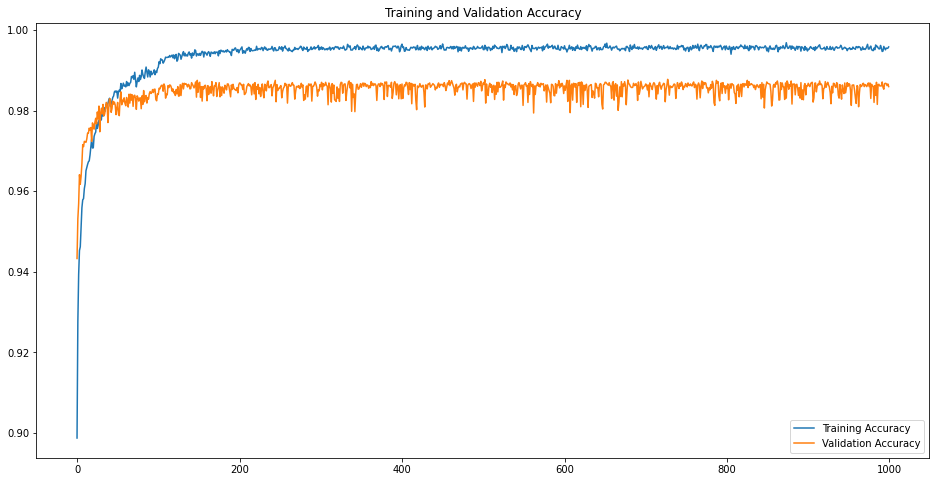

In [28]:
num_epochs=range(1000)
plt.figure(figsize=(16, 8))
plt.plot(num_epochs, train_acc, label='Training Accuracy')
plt.plot(num_epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('10.acc.jpg')
plt.show()

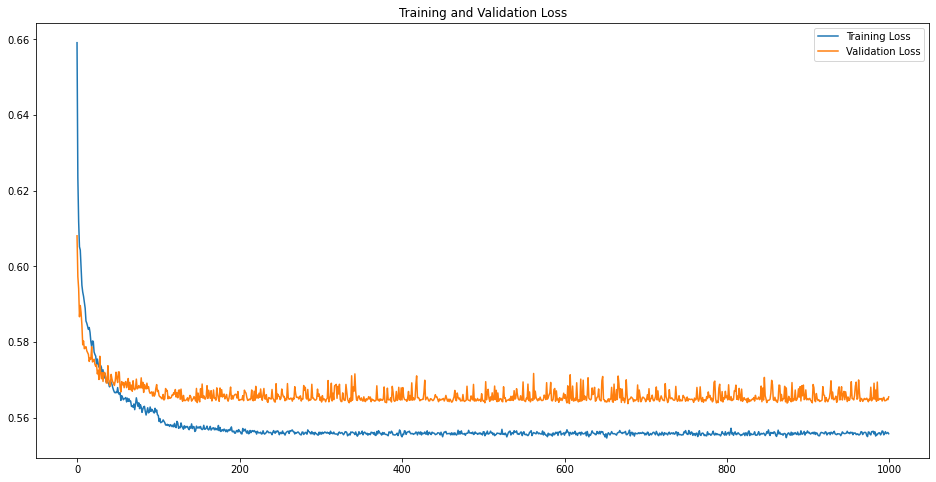

In [29]:
num_epochs=range(1000)
plt.figure(figsize=(16, 8))
plt.plot(num_epochs, train_loss, label='Training Loss')
plt.plot(num_epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('10_loss.jpg')
plt.show()

In [1]:
import numpy as np

In [5]:
np.zeros([1, 170]).shape

(1, 170)

In [6]:
import torch

In [8]:
torch.zeros([5,34]).shape

torch.Size([5, 34])